Importing numpy

In [1]:
import numpy as np

## First, add this file to your drive [File](https://drive.google.com/drive/folders/1T1ox5SBkEf5QDn1w07f2w2teXbpPOjQX?usp=sharing)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Then mount your drive using colab's icon in the files section to the left


In [3]:
features= np.load('/content/drive/MyDrive/NMA_DL_project/feature_0.npy')
labels= np.load('/content/drive/MyDrive/NMA_DL_project/labels.npy')

Making sure that the data has the correct length

In [4]:
assert len(features)==len(labels)

In [5]:
features.shape

(990, 128, 645)

In [6]:
features=features.reshape(990,1,128,645)
features.shape

(990, 1, 128, 645)

In [7]:
import os
import glob
import imageio
import random, shutil
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as display
import librosa
import librosa.display

In [60]:
from  sklearn.model_selection import train_test_split 
x_train , x_test , y_train , y_test = train_test_split( features , labels , train_size=0.7, stratify=labels )

# changing them into torch format
x_train = torch.tensor(x_train )
x_test = torch.tensor(x_test)

y_train =torch.tensor(y_train)
y_test = torch.tensor(y_test)

train = torch.utils.data.TensorDataset(x_train,y_train)
test = torch.utils.data.TensorDataset(x_test,y_test)

train_loader=torch.utils.data.DataLoader(train,batch_size=8,
                                         transforms. , # add transform here
                                         shuffle=True)
test_loader=torch.utils.data.DataLoader(test,batch_size=8)

In [41]:
len(train_loader)

99

In [33]:
train.tensors[0].shape

torch.Size([792, 1, 128, 645])

In [45]:
x_train.shape

torch.Size([792, 1, 128, 645])

In [44]:
y_train.shape

torch.Size([792])

In [12]:
len(x_train)

792

In [13]:
len(y_test)

198

In [82]:
# @title Helper functions (run me)

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
      print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
      print("GPU is enabled in this notebook.")

  return device


#  Plotting function.

def plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc):
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)
  plt.show()
device = set_device()

GPU is enabled in this notebook.


In [83]:
import torch
from torch import nn

import functools
import operator

class music_CNN(nn.Module):
    """Basic Pytorch CNN implementation"""

    def __init__(self, in_channels=1, 
                 out_channels=10,
                 input_dim=(1, 128, 645)):
        
        nn.Module.__init__(self)
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d( 16 ) ,
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),

        )

        num_features_before_fcnn = functools.reduce(operator.mul, list(self.feature_extractor(torch.rand(1, *input_dim)).shape))

        self.classifier = nn.Sequential(
            nn.Linear(in_features=num_features_before_fcnn, out_features=32),
            nn.Dropout(0.4),
            nn.Linear(in_features=32, out_features=out_channels),
        )

    def forward(self, x):
        batch_size = x.size(0)

        out = self.feature_extractor(x)
        out = out.view(batch_size, -1)  # flatten the vector
        out = self.classifier(out)
        return out

In [84]:
def train(model, device, train_loader, validation_loader, epochs):
  criterion =  nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
  train_loss, validation_loss = [], []
  train_acc, validation_acc = [], []
  with tqdm(range(epochs), unit='epoch') as tepochs:
    tepochs.set_description('Training')
    for epoch in tepochs:
      model.train()
      # keep track of the running loss
      running_loss = 0.
      correct, total = 0, 0

      for data, target in train_loader:
        # getting the training set
        data, target = data.to(device, dtype=torch.float ), target.to(device)
        # Get the model output (call the model with the data from this batch)
        output = model(data)
        # Zero the gradients out)
        optimizer.zero_grad()
        # Get the Loss
        loss  = criterion(output, target)
        # Calculate the gradients
        loss.backward()
        # Update the weights (using the training step of the optimizer)
        optimizer.step()

        tepochs.set_postfix(loss=loss.item())
        running_loss += loss  # add the loss for this batch

        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      # append the loss for this epoch
      train_loss.append(running_loss/len(train_loader))
      train_acc.append(correct/total)

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0

      for data, target in validation_loader:
        # getting the validation set
        data, target = data.to(device, dtype=torch.float), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        tepochs.set_postfix(loss=loss.item())
        running_loss += loss.item()
        # get accuracy
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(validation_loader))
      validation_acc.append(correct/total)
      print(f'The Train accuracy= {train_acc[epoch]} \n The Validation acc {validation_acc[epoch]}') 
      print(f'The Train loss= {train_loss[epoch]} \n The Validation loss {validation_loss[epoch]}')  
      print('\n')
  return train_loss, train_acc, validation_loss, validation_acc

The Train accuracy= 0.227994227994228 
 The Validation acc 0.4478114478114478
The Train loss= 3.6044816970825195 
 The Validation loss 1.612493281693835


The Train accuracy= 0.6334776334776335 
 The Validation acc 0.45791245791245794
The Train loss= 1.1058337688446045 
 The Validation loss 1.672966265364697


The Train accuracy= 0.8297258297258298 
 The Validation acc 0.4882154882154882
The Train loss= 0.5724167823791504 
 The Validation loss 1.5118760768520205


The Train accuracy= 0.9466089466089466 
 The Validation acc 0.494949494949495
The Train loss= 0.26252588629722595 
 The Validation loss 1.534821314247031


The Train accuracy= 0.961038961038961 
 The Validation acc 0.4377104377104377
The Train loss= 0.21059739589691162 
 The Validation loss 1.9009292110016471


The Train accuracy= 0.9754689754689755 
 The Validation acc 0.5521885521885522
The Train loss= 0.13693715631961823 
 The Validation loss 1.4156184114123647


The Train accuracy= 0.9913419913419913 
 The Validation acc 

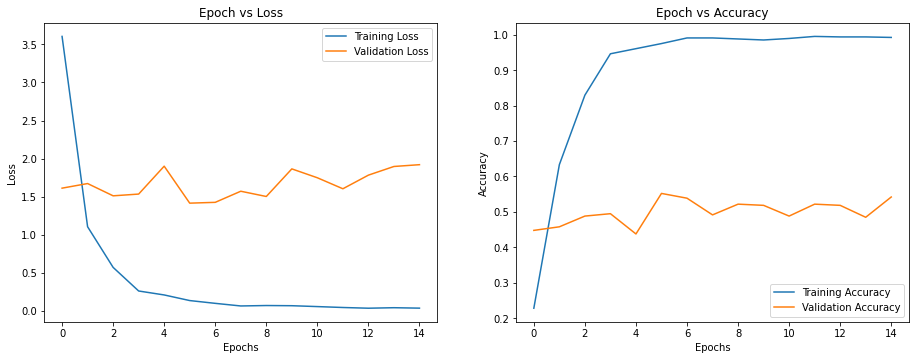

In [85]:
net = music_CNN().to(device)
train_loss, train_acc, validation_loss, validation_acc = train(net, device, train_loader,test_loader, 15)
plot_loss_accuracy(train_loss, train_acc, validation_loss, validation_acc)